# Cuisine Clustering

In [381]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

Yummly provided a dataset with recipe ingredients and the couisine's country that the recipes fall into. 

## Load JSON file and create term count matrix

There are over 30,000 recipes. In order to cluster a cuisine with similar cuisines, all recipes for each cuisine are combined into one master recipe list. 

There are 20 unique cuisines. 

In [2]:
with open('train.json') as data_file:    
    data = json.load(data_file)

Create a dataframe with each recipe as a row

In [3]:
recipe_df = pd.DataFrame(data)
recipe_df = recipe_df.drop("id", axis=1)

Isolate the ingredients column in the dataframe

In [4]:
recipe_ingredients = recipe_df.ingredients

Create a list of recipes that contains all of the recipes in the data

In [5]:
recipe_master_list = [' '.join(ingredients) for ingredients in recipe_ingredients]

Create a count vectorizer from the ingredient master list

In [6]:
# count_vectorizer = CountVectorizer()
# cv = count_vectorizer.fit_transform(recipe_master_list)
# recipe_count_vector = cv.toarray()

In [7]:
# tfidfvectorizer = TfidfVectorizer(stop_words = "english", max_df=95)
# tv = tfidfvectorizer.fit_transform(recipe_master_list)
# tv = tv.toarray()

In [8]:
# svd1 = TruncatedSVD(n_components=1000, n_iter=10)
# normalizer = Normalizer(copy=False)
# lsa = make_pipeline(svd1, normalizer)
# SVD_reduced = svd1.fit_transform(tv)

In [9]:
# sum(svd1.explained_variance_ratio_)

In [88]:
def cuisine_list(data):
    '''function takes in list of json and returns dictionary of all unique cuisines 
    and each ingredient from the cuisines' recipes'''

    cuisine_dictionary = {}
    ingredient_list = []
    cuisine_list = []
    
    for d in data:
        cuisine = d["cuisine"]
        cuisine_list.append(cuisine)
        ingredients = d["ingredients"]
        cuisine_dictionary.setdefault(cuisine, []).append(ingredients)
        for ingredient in ingredients:
            ingredient_list.append(ingredient)
        
    ingredient_list = list(set(ingredient_list))
    cuisine_list = list(set(cuisine_list))
    return cuisine_dictionary, ingredient_list, cuisine_list

In [89]:
cuisine_dict, ingredient_list, cuisine_list = cuisine_list(data)

In [90]:
def clustering_dict(dict):
    '''takes in dictionary of cuisines and their recipes. Returns one list of recipes per cuisine'''
    for key in dict:
        ingredients = dict[key]
        text = [' '.join(ingredient) for ingredient in ingredients]
        dict[key] = text
    return dict

In [91]:
#d1 = (clustering_dict(cuisine_dict))

In [92]:
def join_string(dict):
    '''takes in dictionary of cuisines and recipes, make recipe into one document for vectorizer'''
    for key in dict:
        recipe = dict[key]
        r = [' '.join(recipe)]
        dict[key] = r
    return dict

In [93]:
#d2 = join_string(d1)

In [94]:
#cuisine_df = pd.DataFrame(d2)

In [96]:
cuisine_df

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,ice cubes club soda white rum lime turbinado e...,greek yogurt lemon curd confectioners sugar ra...,herbs lemon juice fresh tomatoes paprika mango...,low sodium soy sauce fresh ginger dry mustard ...,eggs pepper salt mayonaise cooking oil green c...,sugar salt fennel bulb water lemon olive oil g...,romaine lettuce black olives grape tomatoes ga...,water vegetable oil wheat salt black pepper sh...,cooking spray salt black pepper yukon gold pot...,sugar pistachio nuts white almond bark flour v...,plain flour sugar butter eggs fresh ginger roo...,sirloin mirin yellow onion low sodium soy sauc...,jasmine rice garlic scallions sugar shiitake G...,olive oil purple onion fresh pineapple pork po...,ground cloves whole nutmegs ground ginger grou...,water grits mozzarella cheese salt water dill ...,plain flour ground pepper salt tomatoes ground...,olive oil salt medium shrimp pepper garlic cho...,sugar hot chili asian fish sauce lime juice po...,soy sauce vegetable oil red bell pepper chicke...


A handwritten vectorizer, the actual clustering uses sklearn

In [12]:
def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    """This function creates a count matrix. For each ingredient in every cuisine, a count is recorded in a 
    matrix each time ingredient is used"""
    termCountMatrix = np.zeros((numCuisines, numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = cuisine_dict[cuisine]

        for ingredients in ingredientsPerCuisine:
            for item in ingredients:
                j = ingredients.index(item)
                #in order to know which column to put the term count in, we will ago according to the terms' order in the ingredients array
                termCountMatrix[i,j] += 1

        i += 1

    return termCountMatrix

In [13]:
cuisine_count = len(cuisine_list)
ingredient_count = len(ingredient_list)

In [14]:
term_counts = create_term_count_matrix(cuisine_dict, cuisine_count, ingredient_count, cuisine_list, ingredient_list)

In [392]:
pd.DataFrame(term_counts)

,0,1,2,3,4,5,6,7,8,9,...,6704,6705,6706,6707,6708,6709,6710,6711,6712,6713
0,3003.0,2997.0,2984.0,2957.0,2911.0,2812.0,2687.0,2534.0,2376.0,2175.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,825.0,824.0,814.0,805.0,787.0,769.0,723.0,666.0,628.0,576.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,755.0,755.0,752.0,743.0,716.0,672.0,612.0,557.0,487.0,400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,489.0,489.0,488.0,477.0,462.0,440.0,405.0,364.0,313.0,246.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6439.0,6437.0,6417.0,6347.0,6164.0,5873.0,5363.0,4782.0,4174.0,3607.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,804.0,804.0,801.0,783.0,742.0,671.0,615.0,530.0,456.0,388.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,526.0,526.0,525.0,520.0,513.0,502.0,477.0,447.0,408.0,353.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,821.0,821.0,820.0,808.0,787.0,767.0,745.0,704.0,659.0,607.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4320.0,4319.0,4297.0,4205.0,4057.0,3780.0,3447.0,2980.0,2456.0,1976.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1176.0,1175.0,1172.0,1161.0,1131.0,1065.0,984.0,879.0,755.0,640.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TF-IDF

Vectorize cuisine ingredients and use tfidf to account for common ingredients accross all recipes (ie salt)

In [15]:
def tfidf_matrix(X):
    X = sparse.csr_matrix(X)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(X) # normalizes vectors to mean 0 and std 1 and computes tf-idf
    tfidf.toarray() 
    return tfidf.toarray()

In [16]:
tfidf_matrix = tfidf_matrix(term_counts)

In [99]:
#pd.DataFrame(tfidf_matrix, columns=tfidf_matrix.get_feature_names())

In [110]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95)
tfidf_vector_matrix = tfidf_vectorizer.fit_transform(cuisine_df)

## PCA

Use PCA to reduce dimensionality and help with visualizations on lower dimensional graph

In [118]:
pca2 = PCA(n_components=3)
PCA_reduced2 = pca2.fit_transform(term_counts)

Percent of variance explained by first few vectors

In [119]:
pca2.explained_variance_ratio_

array([  9.88679838e-01,   1.07371983e-02,   5.13481191e-04])

## SVD 

Note that SVD does a poor job of reducing variance. PCA should be used to reduce dimensionality instead

In [124]:
svd2 = TruncatedSVD(n_components=3, n_iter=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd2, normalizer)
SVD_reduced2 = svd2.fit_transform(term_counts)

In [125]:
sum(svd2.explained_variance_ratio_)

0.99992324379009789

## K-Means

In this section k-means is used to cluster cuisines with similar cuisines.
In order to determine the best k-number of clusters, a loop is run to calculate silhouette scores 
accross multiple K values. 

In [32]:
n_clusters = [2,3,4,5,6,7,8,9,10]

In [33]:
def compare_kmeans(X, n_clusters):
    for k in n_clusters:
        km = KMeans(n_clusters=k, init="k-means++", n_init=10)
        km.fit(X)
        print(k)
        print(silhouette_score(X, km.labels_))
        print(km.inertia_)
        

In [126]:
compare_kmeans(SVD_reduced2, n_clusters)

2
0.720828108271
156122669.103
3
0.704704605186
41568722.4137
4
0.541579129118
28223443.3886
5
0.522395890386
16994195.7147
6
0.468356862397
9893964.99254
7
0.439010319565
6565135.09296
8
0.397552330594
3671264.70343
9
0.425716862659
1985233.39494
10
0.386423024543
1152579.61476


In [127]:
km = KMeans(n_clusters=4, init="k-means++", n_init=10).fit(SVD_reduced2)

In [128]:
labels = list(km.labels_)

In [203]:
def labels_to_cuisines(cuisines, labels):
    d = {}
    for i in range(len(cuisines)):
        d[cuisines[i]] = labels[i]
    return(d)


In [130]:
labels_to_cuisines(cuisine_list, labels)

{'indian': 2, 'vietnamese': 0, 'filipino': 0, 'russian': 0, 'mexican': 1, 'british': 0, 'jamaican': 0, 'moroccan': 0, 'southern_us': 2, 'greek': 3, 'spanish': 0, 'brazilian': 0, 'japanese': 3, 'korean': 0, 'chinese': 2, 'french': 2, 'italian': 1, 'thai': 3, 'cajun_creole': 3, 'irish': 0}


## Hierarchical document clustering

In [132]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(SVD_reduced2)
titles = list(cuisine_dict)

In [192]:
len(Z)

19

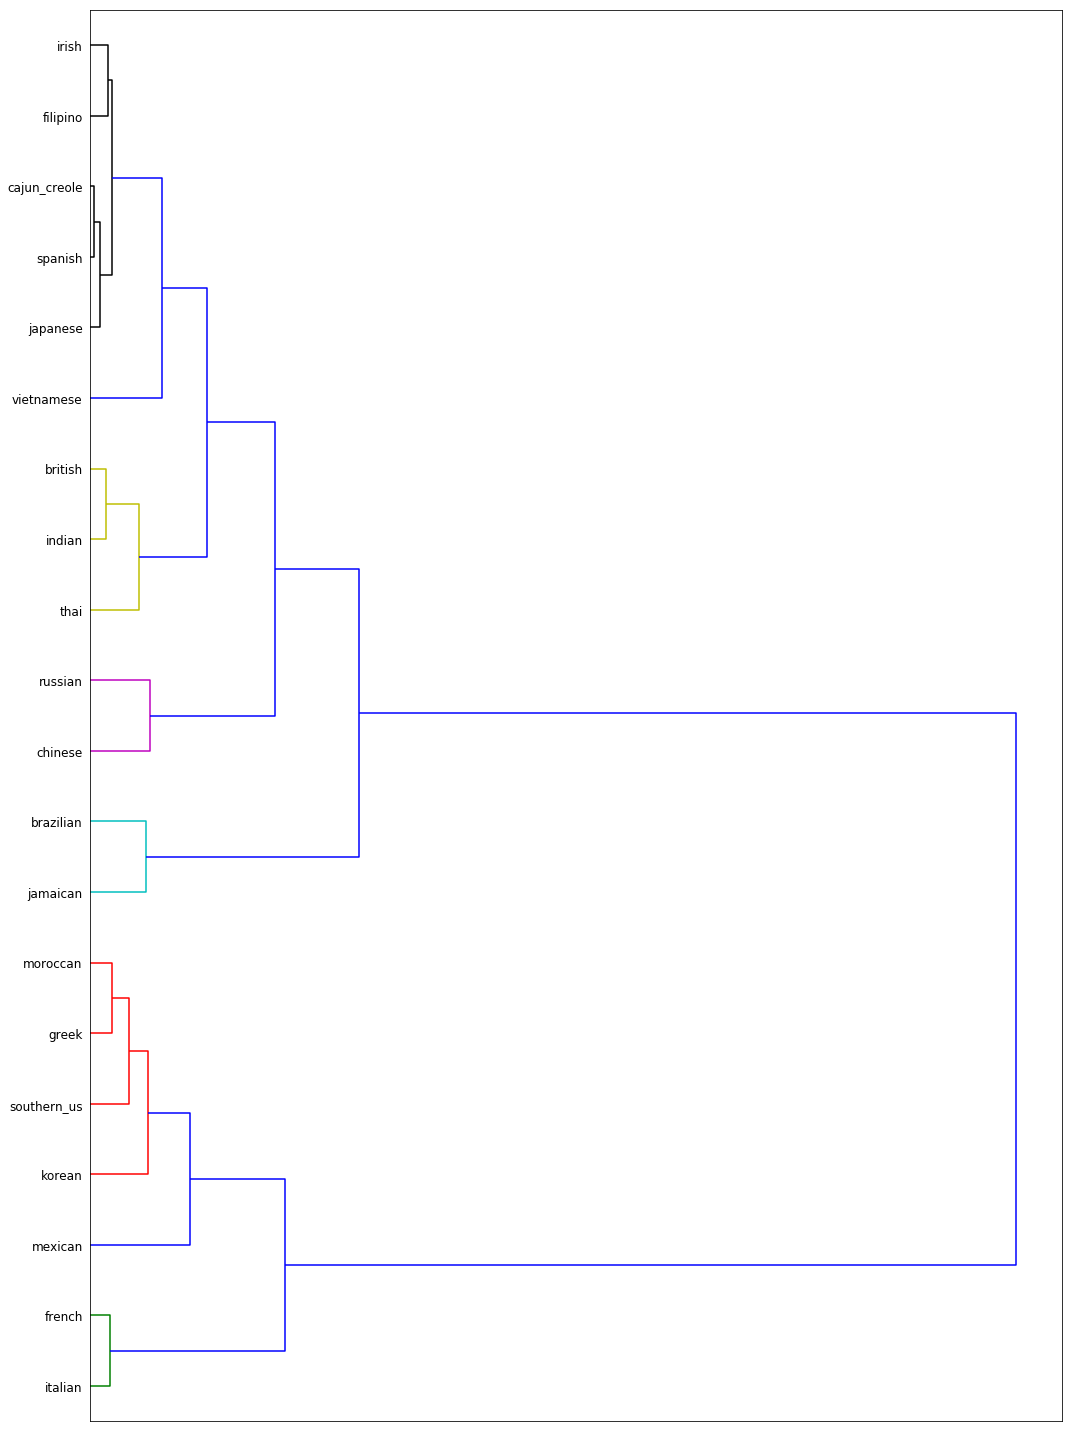

In [394]:
from scipy.cluster.hierarchy import ward, dendrogram, single, complete, weighted

Z = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
    
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(Z, orientation="right", labels=titles, color_threshold=.0175);
#dendrogram(linkage_matrix, orientation="right", labels=titles)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure

#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.show()


In [329]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, criterion="distance", t=.0175)


array([2, 2, 7, 6, 4, 7, 1, 3, 5, 6, 6, 8, 7, 4, 1, 7, 7, 2, 2, 5], dtype=int32)

In [385]:
with open('cluster_df.pkl', 'wb') as f:
   pickle.dump(cluster_df, f, protocol=pickle.HIGHEST_PROTOCOL)

Create a dictionary that matches the cuisine to it's cluster

In [330]:
cuisine_to_cluster_dict = labels_to_cuisines(titles, clusters)

In [331]:
cluster_df = pd.DataFrame(cuisine_to_cluster_dict, index=[1])

In [332]:
cluster_df

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
1,4,6,7,5,7,1,2,6,7,1,4,7,2,3,2,5,2,7,6,8


In [333]:
cluster_df["brazilian"]

1    4
Name: brazilian, dtype: int32

Create a function that takes a cuisine as input and returns other cuisines in the cluster

In [373]:
def similar_cuisines(cuisine, df, titles):
    
    similar_cuisines = []
    cluster = int(df[cuisine])
    
    for title in titles:
        cluster_compare = int(df[title])
        if cluster == cluster_compare:
            similar_cuisines.append(title)
    if cuisine == "vietnamese":
        similar_cuisines.append("korean")
    if cuisine == "mexican":
        similar_cuisines.append("brazilian")
    similar_cuisines.remove(cuisine)
    return(similar_cuisines)
        

In [388]:
similar_cuisines("indian", cluster_df, titles)

['british', 'thai']

In [386]:
titles

['greek',
 'southern_us',
 'filipino',
 'indian',
 'jamaican',
 'spanish',
 'italian',
 'mexican',
 'chinese',
 'british',
 'thai',
 'vietnamese',
 'cajun_creole',
 'brazilian',
 'french',
 'japanese',
 'irish',
 'korean',
 'moroccan',
 'russian']